In [1]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from IPython.display import clear_output

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [2]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 1, overlap = 0):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [3]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft,
        hop_length = hop_length, n_mels=645)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [4]:
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(0, lbl.size)] = 1
    return d

def read_data(src_dir, genres, song_samples,
              n_fft=1024, hop_length=512, debug=True, sample=False):
    # Empty array of dicts with the processed features from all files
    arr_specs = []
    arr_genres = []

    # Read files from the folders
    for x, _ in genres.items():
        folder = src_dir + x

        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples]

                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))

                # Convert to dataset of spectograms/melspectograms
                signals, y = splitsongs(signal, genres[x])

                # Convert to "spec" representation
                specs = to_melspectrogram(signals, n_fft, hop_length)

                # Save files
                arr_genres.extend(y)
                arr_specs.extend(specs)
                
                if sample:
                    break

    return np.array(arr_specs), label2onehot(np.array(arr_genres))

In [6]:
# Parameters
direc = 'extended_ballroom/'
song_samples = 660000
genres = {'Chacha' : 0,'Foxtrot' : 1,'Jive' : 2,'Pasodoble' : 3,'Quickstep' : 4,'Rumba' : 5,'Salsa' : 6,
          'Samba' : 7,'Slowwaltz' : 8,'Tango' : 9,'Viennesewaltz' : 10,'Waltz' : 11,'Wcswing' : 12}

In [9]:
# Read the data
# X, y = read_data(gtzan_dir, genres, song_samples, n_fft=2048, hop_length=1024)
# np.save('x_128x645_gtzan_npy.npy', X)
# np.save('y_10x1000_gtzan_npy.npy', y)

In [10]:
# X, y = read_data(gtzan_dir, genres, song_samples, n_fft=2048, hop_length=1024, sample=True)

In [7]:
# X = np.load('x_gtzan_npy.npy', mmap_mode='r')
# y = np.load('y_gtzan_npy.npy', mmap_mode='r').T
# X = np.load('x_128x645_gtzan_npy.npy', mmap_mode='r')
# y = np.load('y_10x1000_gtzan_npy.npy', mmap_mode='r').T
# X = np.load('645_645/x_645x645_gtzan_npy.npy', mmap_mode='r')
# X = np.load('645_645/X_224x224x3.npy', mmap_mode='r')
# y = np.load('645_645/y_10x1000_gtzan_npy.npy', mmap_mode='r').T
X = np.load('X_EB_224.npy', mmap_mode='r')
y = np.load('y_EB_224.npy', mmap_mode='r').T

In [8]:
X.shape, y.shape

((1045, 224, 224, 3), (1045, 13))

In [11]:
# One hot encoding of the labels
# y = to_categorical(y)
# y = y.T

# Data generator

In [12]:
# B = 30
# N = X.shape[0]
# NB = int(np.ceil(N/B))

In [11]:
def X_gen(X, y, B, validation=False):
    N = X.shape[0]
    NB = int(np.ceil(N/B))
    var=0
    if validation:
        var=0
        
    while True:
        idxminibatches = np.random.permutation(NB)

        for k in range(NB):
            i = idxminibatches[k] # index of minibatch
            # Extract i-th minibatch from xtrain and ltrain
            idxsmp = np.arange(B*i, min(B*(i+1), N)) # indices of samples for i-th minibatc
            # X_stack = np.squeeze(np.stack((X[idxsmp],) * 3, -1))

            X_stack = X[idxsmp] + var*np.random.randn(len(idxsmp), \
                                                      X.shape[1], X.shape[2], X.shape[3])  # as data is already 224x224x3

            yield X_stack, y[idxsmp]

In [59]:
# for x1,y1 in X_gen(X_train)

# Dataset Split

In [23]:
# X_stack = np.squeeze(np.stack((X,) * 3, -1))
# X_stack.shape

In [24]:
# X_train = np.load('train_val_split/xtrain_128x129_gtzan_npy.npy')
# y_train = np.load('train_val_split/ytrain_gtzan_npy.npy').T
# X_test = np.load('train_val_split/xval_128x129_gtzan_npy.npy')
# y_test = np.load('train_val_split/yval_gtzan_npy.npy').T

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26) #, stratify = y)

In [13]:
# X_train = np.log10(1+X_train)
# X_test = np.log10(1+X_test)

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(836, 224, 224, 3) (209, 224, 224, 3) (836, 13) (209, 13)


In [15]:
X_train[0].shape, X_train.min(), X_train.max()

((224, 224, 3), 0.0, 0.9952674508094788)

In [15]:
# plt.figure(figsize=(20,20))
# plt.imshow(X_train[400,:,:,:]) #, cmap='gray')

# spectogram = librosa.power_to_db(X_train[0,:,:,0], ref=np.max)
# plt.axes().set_aspect('equal')
# plt.imshow(spectogram, origin="lower", cmap=plt.get_cmap('inferno'));
# plt.xlabel('Time -> ')
# plt.ylabel('Frequency -> ')

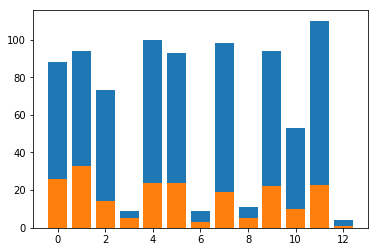

In [16]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# Training

In [25]:
# Model Definition
input_shape =  (X_train[0].shape[0], X_train[0].shape[1], 3)

# (128, 645, 3) X_train[0].shape   # as we shifted stacking inside generator
num_genres = y.shape[1]

def cnn_vgg16(input_shape, num_genres, freezed_layers):
    input_tensor = Input(shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet',
                  input_tensor=input_tensor)

    top = Sequential()
    top.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top.add(Dense(256, activation='relu'))
    top.add(Dropout(0.5))
    top.add(Dense(128, activation='relu'))
    top.add(Dropout(0.5))
    top.add(Dense(64, activation='relu'))
    top.add(Dropout(0.5))
    top.add(Dense(num_genres, activation='softmax'))

    model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
    for layer in model.layers[:freezed_layers]:
        layer.trainable = False

    return model

model = cnn_vgg16(input_shape, num_genres, 17)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [26]:
B=30

In [27]:
# Passing whole data
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adam(),
#               metrics=['accuracy'])

# hist = model.fit(X_train, y_train,
#           batch_size=32,
#           epochs=20,
#           verbose=1,
#           validation_data=(X_test, y_test))

In [28]:
filepath = 'vgg_eb_best_model_256-128-64FC.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [29]:
# image data generator
gen = ImageDataGenerator()   # horizontal_flip= True, channel_shift_range=40,

In [36]:
import json

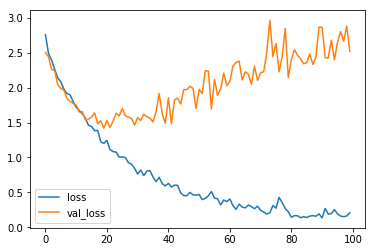


Epoch 00100: val_acc did not improve from 0.63636


In [30]:
# passing generator
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),  # lr=0.01
              metrics=['accuracy'])

# hist = model.fit_generator(X_gen(X_train, y_train, B) , steps_per_epoch = int(np.ceil(X_train.shape[0]/B)),
#           epochs=5, verbose=1,
#           validation_data=X_gen(X_test, y_test, B), validation_steps = int(np.ceil(X_test.shape[0]/B)))

hist = model.fit_generator(gen.flow(X_train, y_train, B) , steps_per_epoch = int(np.ceil(X_train.shape[0]/B)),
          epochs=100, verbose=1,
          # validation_data=X_gen(X_test, y_test, B, True), validation_steps = int(np.ceil(X_test.shape[0]/B))
          validation_data=[X_test, y_test],
            callbacks = [plot_losses,checkpoint])

In [ ]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = hist.history
# Save it under the form of a json file
json.dump(history_dict, open('eb_100epochs', 'w'))

In [32]:
# keras.backend.eval(model.optimizer.lr)
model.layers, model.layers[1]

In [39]:
# For Fine tuning the whole model
for layer in model.layers[:10]:
    layer.trainable = True

In [40]:
# fine tuning the whole model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),   # lr=0.01
              metrics=['accuracy'])

hist2 = model.fit_generator(X_gen(X_train, y_train, B) , steps_per_epoch = int(np.ceil(X_train.shape[0]/B)),
          epochs=20,
          verbose=1,
          validation_data=X_gen(X_test, y_test, B), validation_steps = int(np.ceil(X_test.shape[0]/B)))

Epoch 1/20
28/28 [==============================] - 18s 641ms/step - loss: 14.6979 - acc: 0.0881 - val_loss: 15.0384 - val_acc: 0.0670
Epoch 2/20
 4/28 [===>..........................] - ETA: 10s - loss: 15.1779 - acc: 0.0583

KeyboardInterrupt: 

In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

score = model.evaluate(X_train, y_train, verbose=0)
print("train_loss = {:.3f} and train_acc = {:.3f}".format(score[0], score[1]))

train_loss = 0.306 and train_acc = 0.899


In [27]:
score = model.evaluate_generator(X_gen(X_test, y_test, B), steps = int(np.ceil(X_test.shape[0]/B)),verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

score = model.evaluate_generator(X_gen(X_train, y_train, B), steps = int(np.ceil(X_train.shape[0]/B)), verbose=0)
print("train_loss = {:.3f} and train_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.452 and val_acc = 0.906
train_loss = 0.074 and train_acc = 0.982


In [22]:
preds = model.predict_generator(X_gen(X_test, y_test, B), steps = int(np.ceil(X_test.shape[0]/B)),verbose=0)

In [23]:
#plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

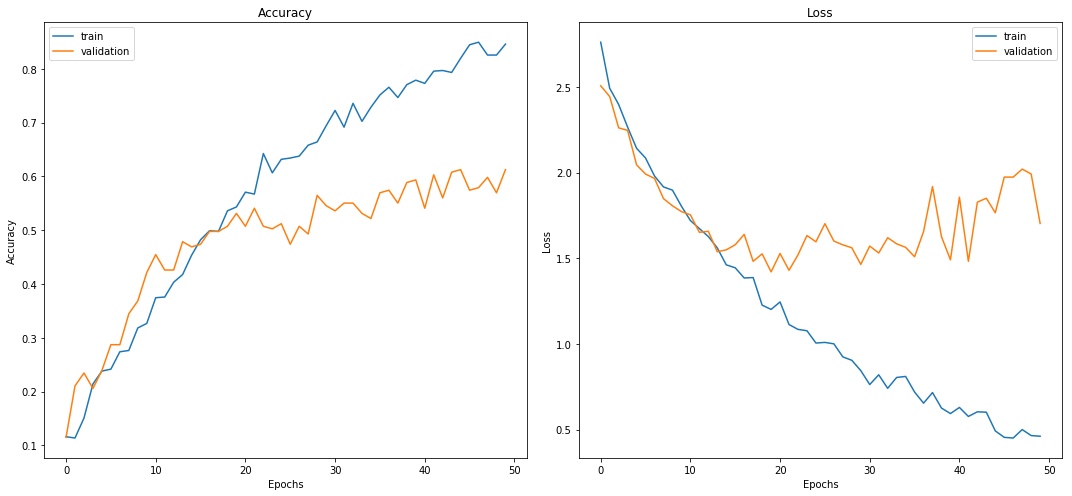

In [34]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'][0:50], label='train')
plt.plot(hist.history['val_acc'][0:50], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'][0:50], label='train')
plt.plot(hist.history['val_loss'][0:50],label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


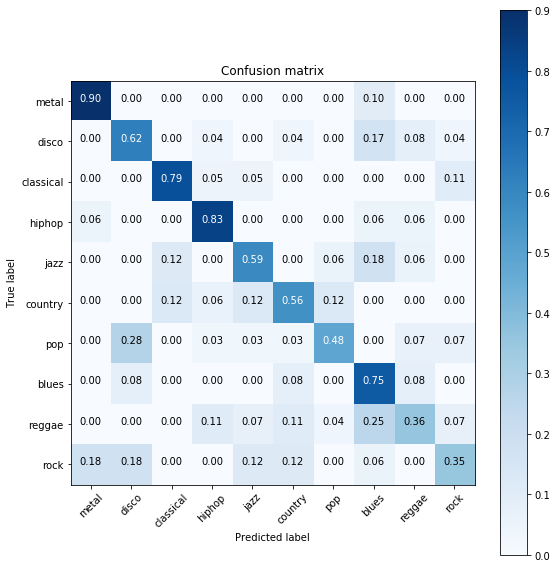

In [28]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

## Save the model

In [25]:
# Save the model
# model.save('../models/vgg16_10epFClearn_20epFullLearn.h5')